## Implement a Conditional GAN for Attribute-Based Image Generation on CelebA

The objective of this assignment is to develop and train a Conditional Generative Adversarial Network (cGAN) model. This cGAN will be specifically designed to generate realistic facial images from the CelebA dataset, conditioned on eight key attributes:

1. Eyeglasses
2. Wearing a Hat
3. Bangs
4. Wavy Hair
5. Pointy Nose
6. Mustache
6. Oval Face
8. Smiling


Important Note: The CelebA dataset contains 40 different facial attributes. For this assignment, you will focus solely on training your cGAN to generate images based on the eight attributes listed above.


!["CelebA"](https://mmlab.ie.cuhk.edu.hk/projects/CelebA/overview.png)



#1.Dataset
CelebFaces Attributes Dataset (CelebA) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter. CelebA has large diversities, large quantities, and rich annotations, including



*   10,177 number of identities,
*   202,599 number of face images, and
*   5 landmark locations, 40 binary attributes annotations per image.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import CelebA
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from google.colab import drive
import os
from torch.utils.data import Dataset # Import the Dataset class
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import os
from PIL import Image

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content
%cd /content/drive/MyDrive/CelebA

/content
/content/drive/MyDrive/CelebA


In [5]:
class CelebADataset(Dataset):
    def __init__(self, img_dir, attr_path, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.attrs = self.load_attributes(attr_path)
        self.imgs = sorted(os.listdir(self.img_dir))  # Ensure sorted to match the attribute file order

    def load_attributes(self, attr_path):
        with open(attr_path, 'r') as f:
            lines = f.readlines()
            attr_names = lines[1].split()
            attrs = {}
            for line in lines[2:]:
                parts = line.split()
                img_name = parts[0]
                # Convert -1 to 0 in the attributes
                attr_values = [0 if x.strip() == '-1' else 1 for x in parts[1:]]  # Handle hyphens
                attrs[img_name] = torch.tensor(attr_values, dtype=torch.float32)
        return attrs

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        attributes = self.attrs[img_name]
        return image, attributes

##DataLoader

In [7]:
# Dataset and DataLoader
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = CelebADataset(img_dir='/content/drive/MyDrive/CelebA/img_align_celeba', attr_path='/content/drive/MyDrive/CelebA/list_attr_celeba.txt', transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)

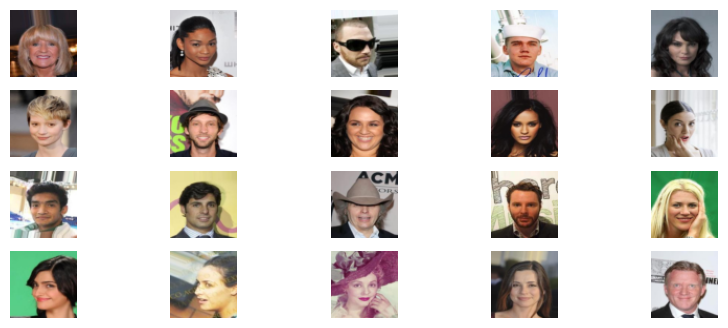

In [22]:
# Display a batch of images
dataiter = iter(dataloader)
images, labels = next(dataiter)

# Display the images
plt.figure(figsize=(10, 4))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    image = images[i].permute(1, 2, 0)  # Permute to (H, W, C)
    image = (image + 1) / 2  # Denormalize
    plt.imshow(image)
    plt.axis('off')
plt.show()

# 2.Conditional Generative Adversarial Network (cGAN) modeL

- Generator: The Generator takes two inputs: a latent vector (noise) and a set of attributes.

- Discriminator:The Discriminator takes two inputs: an input image and a set of attributes.

In [8]:
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CelebA
import matplotlib.pyplot as plt
import os
# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, output_channels, num_attributes):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.output_channels = output_channels
        self.num_attributes = num_attributes

        self.main = nn.Sequential(
            nn.Linear(latent_dim + num_attributes, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            nn.Linear(1024, 64 * 64 * output_channels),
            nn.Tanh()
        )

    def forward(self, noise, attributes):
        noise = noise.view(-1, self.latent_dim)  # Reshape noise to 2D
        attributes = attributes.float() # Cast attributes to float
        input = torch.cat((noise, attributes), dim=1)  # Concatenate along the second dimension
        output = self.main(input)
        return output.view(-1, self.output_channels, 64, 64)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_channels, num_attributes):
        super(Discriminator, self).__init__()
        self.input_channels = input_channels
        self.num_attributes = num_attributes

        self.main = nn.Sequential(
            nn.Conv2d(input_channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1 + num_attributes, 4, 1, 0, bias=False),
            # Add a sigmoid activation for the adversarial output
            nn.Sigmoid()
        )

    def forward(self, input, attributes):
        output = self.main(input)
        return output[:, 0].view(-1, 1), output[:, 1:] # Reshape adversarial output to match target shape

## Loss

- adversarial_loss: This is the binary cross-entropy loss, which will be used to train the discriminator to distinguish real from fake images.

- auxiliary_loss: This is the cross-entropy loss, which will be used to train the discriminator to predict the attributes of the input images.

In [9]:
# Set up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the generator and discriminator
generator = Generator(latent_dim=100, output_channels=3, num_attributes=40).to(device)
discriminator = Discriminator(input_channels=3, num_attributes=40).to(device)

# Define the optimizers with different learning rates and beta values
g_optimizer = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.9, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Define the loss functions
adversarial_loss = nn.BCELoss()
auxiliary_loss = nn.CrossEntropyLoss()

# 3.Train

In [10]:
from torchvision.utils import save_image
# Training loop
num_epochs = 100
g_losses = []
d_losses = []

for epoch in range(num_epochs):
    # Train the discriminator
    discriminator.zero_grad()
    real_samples, real_labels = next(iter(dataloader))
    real_samples, real_labels = real_samples.to(device), real_labels.to(device)
    # Create a tensor of random attributes
    fake_attributes = torch.randint(2, (real_samples.size(0), generator.num_attributes), device=device)
    # Pass both noise and attributes to the generator
    fake_samples = generator(torch.randn(real_samples.size(0), 100, 1, 1, device=device), fake_attributes)
    # Pass both real samples and their attributes to the discriminator
    d_real_output, d_real_aux_output = discriminator(real_samples, real_labels) # Pass real_labels as attributes
    d_fake_output, d_fake_aux_output = discriminator(fake_samples.detach(), fake_attributes) # Pass fake attributes
    d_loss_real = adversarial_loss(d_real_output, torch.ones_like(d_real_output))
    d_loss_fake = adversarial_loss(d_fake_output, torch.zeros_like(d_fake_output))
    d_real_aux_output = d_real_aux_output.squeeze()  # Remove the singleton dimensions
    d_fake_aux_output = d_fake_aux_output.squeeze()  # Remove the singleton dimensions
    real_labels_2d = real_labels.view(-1, generator.num_attributes)

    d_loss_aux = auxiliary_loss(d_real_aux_output, real_labels_2d) # Calculate auxiliary loss with reshaped tensors
 # Calculate auxiliary loss with reshaped tensors
    d_loss = (d_loss_real + d_loss_fake) / 2 + d_loss_aux
    d_loss.backward()
    d_optimizer.step()
    d_losses.append(d_loss.item())

    # Train the generator
    generator.zero_grad()
    # Create a tensor of random attributes
    fake_attributes = torch.randint(2, (real_samples.size(0), generator.num_attributes), device=device)
    # Pass both noise and attributes to the generator
    fake_samples = generator(torch.randn(real_samples.size(0), 100, 1, 1, device=device), fake_attributes)
    g_output, g_aux_output = discriminator(fake_samples, fake_attributes) # Pass fake_attributes to discriminator
    g_loss_adv = adversarial_loss(g_output, torch.ones_like(g_output))
    g_loss_aux = auxiliary_loss(g_aux_output.squeeze(), fake_attributes.float()) # Pass fake_attributes to auxiliary loss and squeeze g_aux_output
    g_loss = g_loss_adv + g_loss_aux
    g_loss.backward()
    g_optimizer.step()
    g_losses.append(g_loss.item())

    # Save generated samples
    if (epoch + 1) % 10 == 0:
        save_image(fake_samples[:64], f"generated_samples_{epoch+1}.png", nrow=8, normalize=True)

    print(f"Epoch [{epoch+1}/{num_epochs}], D_loss: {d_loss.item()}, G_loss: {g_loss.item()}")

Epoch [1/100], D_loss: 35.923160552978516, G_loss: 77.7346420288086
Epoch [2/100], D_loss: 30.966215133666992, G_loss: 79.38424682617188
Epoch [3/100], D_loss: 32.862762451171875, G_loss: 80.07444763183594
Epoch [4/100], D_loss: 29.405710220336914, G_loss: 79.73851776123047
Epoch [5/100], D_loss: 30.812618255615234, G_loss: 77.56100463867188
Epoch [6/100], D_loss: 32.88767623901367, G_loss: 79.76319885253906
Epoch [7/100], D_loss: 33.28511428833008, G_loss: 80.10794067382812
Epoch [8/100], D_loss: 28.230031967163086, G_loss: 82.8826904296875
Epoch [9/100], D_loss: 32.26229476928711, G_loss: 80.82903289794922
Epoch [10/100], D_loss: 29.98568344116211, G_loss: 78.125
Epoch [11/100], D_loss: 29.7536678314209, G_loss: 80.35758972167969
Epoch [12/100], D_loss: 31.614749908447266, G_loss: 82.14511108398438
Epoch [13/100], D_loss: 30.799882888793945, G_loss: 82.99703216552734
Epoch [14/100], D_loss: 31.237274169921875, G_loss: 78.4332504272461
Epoch [15/100], D_loss: 30.44565200805664, G_loss

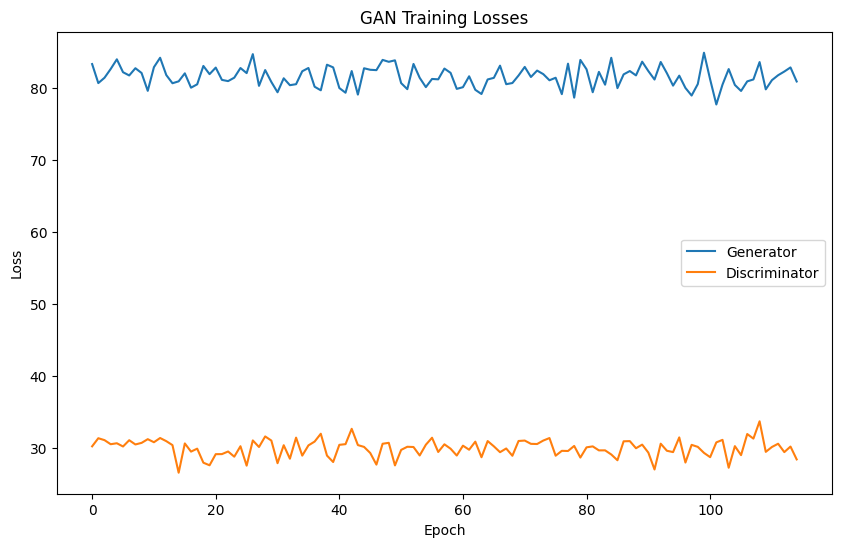

In [12]:
# Plot the generator and discriminator losses
plt.figure(figsize=(10, 6))
plt.plot(g_losses, label='Generator')
plt.plot(d_losses, label='Discriminator')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Losses')
plt.legend()
plt.savefig('training_losses.png')
plt.show()

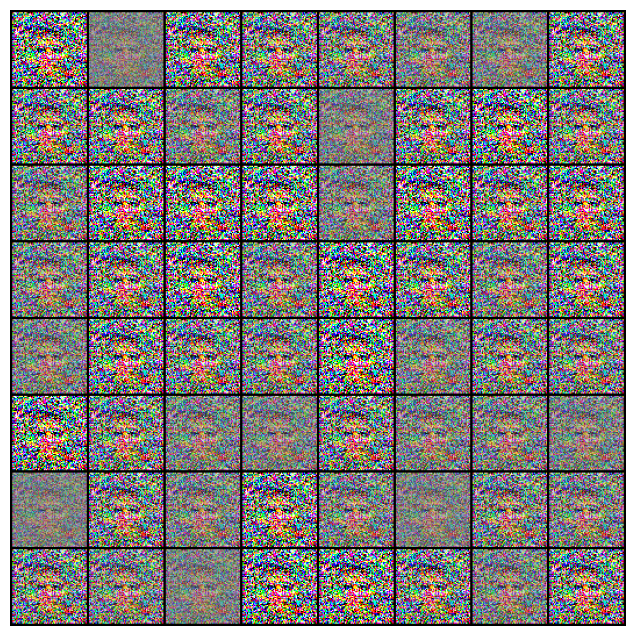

In [18]:
#show image gneret

import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Load the generated image
img = vutils.make_grid(fake_samples[:64], padding=2, normalize=True)

# Convert the tensor to a numpy array
img = img.cpu().numpy()

# Plot the image
plt.figure(figsize=(8,8))
plt.imshow(img.transpose((1, 2, 0)))
plt.axis("off")
plt.show()

# Another training

In [ ]:
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator(latent_dim=100, output_channels=3, num_attributes=40).to(device)
discriminator = Discriminator(input_channels=3, num_attributes=40).to(device)

g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

num_epochs = 50

- 1. Loss Functions:
   - First: Uses custom `adversarial_loss` and `auxiliary_loss` functions.
   - Second: Uses PyTorch's built-in `F.binary_cross_entropy_with_logits` and `F.mse_loss`.

In [ ]:
num_epochs = 50
for epoch in range(num_epochs):
    for i, (real_images, real_attributes) in enumerate(dataloader):
        real_attributes = real_attributes.unsqueeze(1).unsqueeze(2)
        real_images, real_attributes = real_images.to(device), real_attributes.to(device)

        # Train the discriminator
        d_optimizer.zero_grad()
        real_output, real_aux = discriminator(real_images, real_attributes)
        real_loss = F.binary_cross_entropy_with_logits(real_output, torch.ones_like(real_output))

        # Permute the dimensions of real_aux to match real_attributes
        real_aux = real_aux.permute(0, 2, 3, 1)
        real_aux_loss = F.binary_cross_entropy_with_logits(real_aux, real_attributes)

        d_real_loss = real_loss + real_aux_loss

        noise = torch.randn(real_images.size(0), generator.latent_dim).to(device)
        fake_attributes = torch.randn(real_images.size(0), generator.num_attributes).to(device)
        fake_images = generator(noise, fake_attributes)
        fake_output, fake_aux = discriminator(fake_images.detach(), fake_attributes)
        fake_loss = F.binary_cross_entropy_with_logits(fake_output, torch.zeros_like(fake_output))

        # Permute the dimensions of fake_aux to match fake_attributes
        fake_aux = fake_aux.permute(0, 2, 3, 1)
        fake_aux_loss = F.binary_cross_entropy_with_logits(fake_aux, fake_attributes.unsqueeze(1).unsqueeze(2))

        d_fake_loss = fake_loss + fake_aux_loss

        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        d_optimizer.step()

        # Train the generator
        g_optimizer.zero_grad()
        noise = torch.randn(real_images.size(0), generator.latent_dim).to(device)
        fake_attributes = fake_attributes.unsqueeze(1).unsqueeze(1)
        g_aux_loss = F.binary_cross_entropy_with_logits(fake_aux, fake_attributes)
        fake_attributes = torch.randn(real_images.size(0), generator.num_attributes).to(device)
        fake_images = generator(noise, fake_attributes)
        fake_output, fake_aux = discriminator(fake_images, fake_attributes)
        g_loss = F.mse_loss(fake_output, torch.ones_like(fake_output))

        # Permute the dimensions of fake_aux to match fake_attributes
        fake_aux = fake_aux.view(64, 40)
        g_aux_loss = F.binary_cross_entropy_with_logits(fake_aux, fake_attributes)

        g_loss = g_loss + g_aux_loss

        g_loss.backward()
        g_optimizer.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(dataloader)}], D_loss: {d_loss.item()}, G_loss: {g_loss.item()}")

print("Training finished.")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/50], Batch [1/700], D_loss: 0.5680807828903198, G_loss: 65.60929107666016
Epoch [1/50], Batch [2/700], D_loss: 0.5031381845474243, G_loss: 86.62654876708984
Epoch [1/50], Batch [3/700], D_loss: 0.5135316848754883, G_loss: 58.42781066894531
Epoch [1/50], Batch [4/700], D_loss: 0.480441153049469, G_loss: 117.16353607177734
Epoch [1/50], Batch [5/700], D_loss: 0.3624243140220642, G_loss: 78.9263916015625
Epoch [1/50], Batch [6/700], D_loss: 0.34504395723342896, G_loss: 71.6582260131836
Epoch [1/50], Batch [7/700], D_loss: 0.3797817528247833, G_loss: 106.66622161865234
Epoch [1/50], Batch [8/700], D_loss: 0.3226872384548187, G_loss: 77.54891204833984
Epoch [1/50], Batch [9/700], D_loss: 0.3459782600402832, G_loss: 86.85002899169922
Epoch [1/50], Batch [10/700], D_loss: 0.28463178873062134, G_loss: 77.6108627319336
Epoch [1/50], Batch [11/700], D_loss: 0.28234949707984924, G_loss: 75.52723693847656
Epoch [1/50], Batch [12/700], D_loss: 0.25037163496017456, G_loss: 73.53158569335938

RuntimeError: Caught RuntimeError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 316, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 173, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 173, in <listcomp>
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 141, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 212, in collate_tensor_fn
    out = elem.new(storage).resize_(len(batch), *list(elem.size()))
RuntimeError: Trying to resize storage that is not resizable


In [ ]:
print(fake_attributes.shape)
print(fake_aux.shape)
print(fake_attributes.unsqueeze(1).unsqueeze(2).shape)

torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 1, 1, 40])


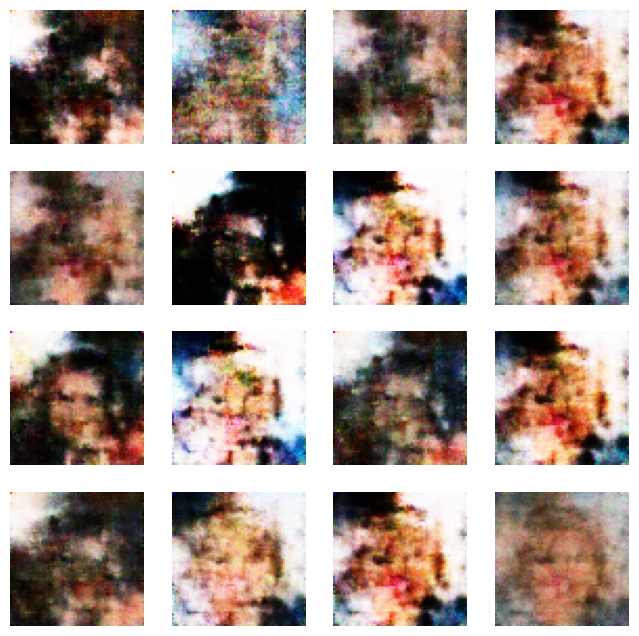

In [ ]:
# Generate images conditioned on specific attributes
desired_attributes = torch.tensor([1, 1, 0, 1, 0, 0, 1, 1]).to(device)  # Binary vector of desired attributes
# Repeat the desired attributes vector along the first dimension to match the batch size of the noise vector
desired_attributes = desired_attributes.repeat(64, 1) # Repeat the attributes vector to match the batch size
noise = torch.randn(64, generator.latent_dim).to(device)

# Pad or truncate the desired_attributes to match the expected input size of the generator
desired_attributes = F.pad(desired_attributes, (0, generator.num_attributes - desired_attributes.shape[1]), "constant", 0)

conditional_images = generator(noise, desired_attributes) # Pass the correctly shaped attributes vector

# Display the generated images
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = conditional_images[i].detach().cpu().permute(1, 2, 0)
    image = (image + 1) / 2  # Denormalize
    plt.imshow(image)
    plt.axis('off')
plt.show()